# IEOR 4571 - Personalization - Final Project

#### Team members: 
Name, UNI/email, Github ID
* Megala Kannan, msk2245@columbia.edu, thisismeg
* Hojin Lee, hl3328@columbia.edu, hjlee9295
* Jung Ah Shin, js5569@columbia.edu, juliajungahshin
* Tiffany Zhu, tz2196@columbia.edu, tlzhu19


# TOC:
* [1. Introduction](#1)
* [2. Data Exploration](#2)
* [3. Modeling](#3)
    * [3.1 Baseline Model: Learned Bias](#3-1)
        * [3.1.1 Accuracy of Learned Bias Model](#3-1-1)
        * [3.1.2 Coverage of Learned Bias Model](#3-1-2)
    * [3.2 Baseline Model: Vanilla Matrix Factorization](#3-2)
        * [3.2.1 Tuning Hyperparameters](#3-2-1)
        * [3.2.2 Accuracy of Vanilla Matrix Factorization Model](#3-2-2)
        * [3.2.3 Coverage of Vanilla Matrix Factorization Model](#3-2-3)
    * [3.3 SVD and Nonnegative Matrix Factorization](#3-3)
    * [3.4 Wide and Deep Model](#3-4)
        * [3.4.1 Feature Selection](#3-4-1)
        * [3.4.2 Feature Engineering](#3-4-2)
        * [3.4.3 Modeling](#3-4-3)
        * [3.4.4 Accuracy](#3-4-4)    
        * [3.4.5 Coverage](#3-4-5)    
* [4. Evaluation](#4)
    * [4.1 Accuracy](#4-1)
    * [4.2 Coverage](#4-2)
    * [4.3 Hold out](#4-3)
* [5. Conclusion](#5)


# 1. Introduction <a class="anchor" id="1"></a>

Yelp is a crowd-sourced review platform where users interact with businesses and other users through writing reviews and discovering new businesses. To make this platform more effective, we leverage various attributes of users, businesses, and reviews to provide better business recommendation for users. Our initial goal is to predict the last rating (final review) for each active user, where active users are those that gave 5 or more reviews. While aiming towards minimizing the difference between the actual rating and our prediction, we also want our recommendation model to provide diverse recommendations so that many users have an opportunity to explore new contents.

In line with our objectives, we decided to explore several recommendation algorithms to gain a better understanding of the advantages and disadvantages each model provides.
We chose Singular Value Decomposition (SVD), Non-negative Matrix Factorization (NMF), and Wide and Deep algorithms. We compare the aforementioned models with two baseline models, which are user and item bias baseline, and a vanilla Matrix Factorization model.

To evaluate and compare the accuracy of our models, we used RMSE. These values would indicate how well our models perform compared to the baseline models. To evaluate the quality and diversity of our models, we used catalog coverage. This would indicate how diverse our business recommendations are. Detailed descriptions of each process is provided below.

# 2. Data Exploration <a class="anchor" id="2"></a>

In [1]:
import pandas as pd
import json
from tqdm import tqdm

import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

import itertools
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

First, we convert all of our json files to Pandas dataframes. We will use review.json, business.json, user.json, tip.json, and photo.json. 

In [2]:
def convert_json_to_df(path, file_name, column_names):
    '''
    converts the json file into a pandas dataframe
    path: string of path
    file_name: string of json file name
    column_names: the names of the json file attributes (used as the dataframe column names)
    returns: dataframe
    '''
    line_count = len(open(path + file_name).readlines())    
    columns_dict = {name: [] for name in column_names}

    with open(path + file_name) as f:
        for line in tqdm(f, total=line_count):
            blob = json.loads(line)
            
            for key in column_names:
                columns_dict[key].append(blob[key])
    
    return pd.DataFrame(columns_dict)

In [3]:
path = "/Users/tiffanyzhu/Downloads/yelp_dataset/"
file_name = "review.json"

In [4]:
# review.json
ratings = convert_json_to_df(path, file_name, ['user_id', 'business_id', 'stars', 'date'])

user_counts = ratings["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()

100%|██████████| 6685900/6685900 [01:20<00:00, 83031.22it/s]


In [5]:
len(active_users)

286130

In [6]:
ratings.rename(columns={'stars': 'rating'}, inplace=True)
ratings.head()

,user_id,business_id,rating,date
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,2013-05-07 04:34:36
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,2017-01-14 21:30:33
2,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,2016-11-09 20:09:03
3,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,2018-01-09 20:56:38
4,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,2018-01-30 23:07:38


In [7]:
# for metadata info see https://www.yelp.com/dataset/documentation/main

In [8]:
# business.json
# todo: how to add 'attributes'?
'''
"attributes": {
        "RestaurantsTakeOut": true,
        "BusinessParking": {
            "garage": false,
            "street": true,
            "validated": false,
            "lot": false,
            "valet": false
        },
'''

businesses = convert_json_to_df(path, 'business.json', ['business_id', 'city', 'state', 'stars', 
                                                        'review_count', 'is_open', 'attributes', 
                                                        'categories', 'hours', 'latitude', 'longitude', 'name'])

100%|██████████| 192609/192609 [00:03<00:00, 52207.81it/s]


In [9]:
businesses.head()

,business_id,city,state,stars,review_count,is_open,attributes,categories,hours,latitude,longitude,name
0,1SWheh84yJXfytovILXOAQ,Phoenix,AZ,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None,33.522143,-112.018481,Arizona Biltmore Golf Club
1,QXAEGFB4oINsVuTFxEYKFQ,Mississauga,ON,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",43.605499,-79.652289,Emerald Chinese Restaurant
2,gnKjwL_1w79qoiV3IC_xQQ,Charlotte,NC,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",35.092564,-80.859132,Musashi Japanese Restaurant
3,xvX2CttrVhyG2z1dFg_0xw,Goodyear,AZ,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",33.455613,-112.395596,Farmers Insurance - Paul Lorenz
4,HhyxOkGAM07SRYtlQ4wMFQ,Charlotte,NC,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",35.190012,-80.887223,Queen City Plumbing


In [10]:
# user.json
users = convert_json_to_df(path, 'user.json', ['user_id', 'review_count', 'friends', 'useful', 
                                               'funny', 'cool', 'fans', 'elite', 'average_stars', 
                                               'compliment_hot', 'compliment_more', 'compliment_profile',
                                               'compliment_cute', 'compliment_list', 'compliment_note',
                                               'compliment_plain', 'compliment_cool', 'compliment_funny',
                                               'compliment_writer', 'compliment_photos'
                                              ])

100%|██████████| 1637138/1637138 [00:42<00:00, 38463.04it/s]


In [11]:
users.head()

,user_id,review_count,friends,useful,funny,cool,fans,elite,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,95,"c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",84,17,25,5,"2015,2016,2017",4.03,2,0,0,0,0,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,33,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",48,22,16,4,,3.63,1,0,0,0,0,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,16,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",28,8,10,0,,3.71,0,0,0,0,0,1,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,17,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",30,4,14,5,,4.85,1,0,0,0,0,0,2,0,0,1,0
4,MM4RJAeH6yuaN8oZDSt0RA,361,"mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",1114,279,665,39,"2015,2016,2017,2018",4.08,28,1,0,0,1,16,57,80,80,25,5


In [12]:
# tip.json
tips =  convert_json_to_df(path, 'tip.json', ['text', 'date', 'compliment_count', 'business_id', 'user_id'])

100%|██████████| 1223094/1223094 [00:12<00:00, 99101.99it/s] 


In [13]:
photos = convert_json_to_df(path, 'photo.json', ['photo_id', 'business_id'])

100%|██████████| 200000/200000 [00:01<00:00, 149443.01it/s]


Exploratory analysis of our data shows some interesting patterns.
The average ratings received by businesses imply that a large number of businesses received 3.5-5.0 stars from users, while only a small number of businesses received a low rating (rating <  3.0). Similarly, by looking at the distribution of ratings by users, the majority of the ratings are concentrated in the upper-half, indicating that most users gave 4.0 to 5.0 in their reviews. It shows that most ratings are positive, whereas only a small amount of ratings were negative (rating <  3.0).  We can hypothesize from this evaluation that since our models will be trained primarily by positive ratings,  it might perform better at predicting ratings for businesses they are likely to enjoy than those they are less likely to enjoy. 

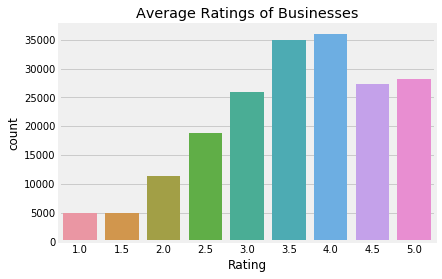

In [14]:
chart = sns.countplot(x='stars',data=businesses)
var = chart.set(xlabel='Rating', title='Average Ratings of Businesses')

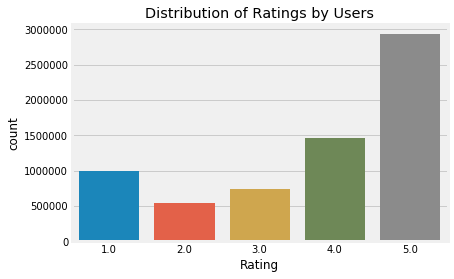

In [15]:
chart = sns.countplot(x='rating',data=ratings)
var = chart.set(xlabel='Rating', title='Distribution of Ratings by Users')

In addition, we also looked at which categories the businesses belong in. Our analysis indicate that the top-5 most common categories are restaurants, shopping, food, home services, and beauty & spas. 
Furthermore, the top-5 most common categories cover approximately 71% of the data, hence these categories are used as features for our Wide and Deep model.

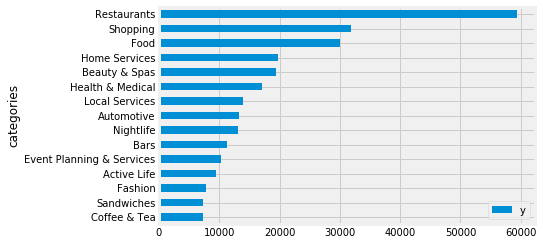

In [16]:
catList = []
businesses['categories'].fillna(value='',inplace=True)
businesses['cat'] = businesses['categories'].apply(lambda x: x.split(','))
catList.extend(businesses['cat'])
merged = [x.strip() for x in list(itertools.chain(*catList))]

mostCommon = Counter(merged).most_common(15)
mostCommonKeys = [x for x in list(itertools.chain(*mostCommon)) if type(x) != int]
mostCommonValues = [x for x in list(itertools.chain(*mostCommon)) if type(x) == int]

df = pd.DataFrame({'y': mostCommonValues, 'categories': mostCommonKeys})
ax = df.plot.barh(x='categories', y='y')
ax.invert_yaxis()

In [17]:
topKBusiness = [5,10,20]

for n in topKBusiness:
    catList = []
    businesses['categories'].fillna(value='',inplace=True)
    businesses['cat'] = businesses['categories'].apply(lambda x: x.split(','))
    catList.extend(businesses['cat'])
    merged = [x.strip() for x in list(itertools.chain(*catList))]
    mostCommon = Counter(merged).most_common(n)
    mostCommonKeys = [x for x in list(itertools.chain(*mostCommon)) if type(x) != int]
    mostCommonValues = [x for x in list(itertools.chain(*mostCommon)) if type(x) == int]

    colName = 'Top' + str(n)
    businesses[colName] = businesses['cat'].apply(lambda categories: 1 if bool(set([y.strip() for y in categories]).intersection(mostCommonKeys)) else 0)   
    print('business covered percentage when k =', n, ":", businesses[colName].mean())

business covered percentage when k = 5 : 0.7069243908643936
business covered percentage when k = 10 : 0.8770670114065282
business covered percentage when k = 20 : 0.9306418703175864


To see which specific businesses might have received the highest number of ratings, Starbucks overall received the most number of ratings,  followed by McDonald’s and Hash House A Go Go. We could observe that franchise businesses tend to have many reviews due to having branches in various locations.

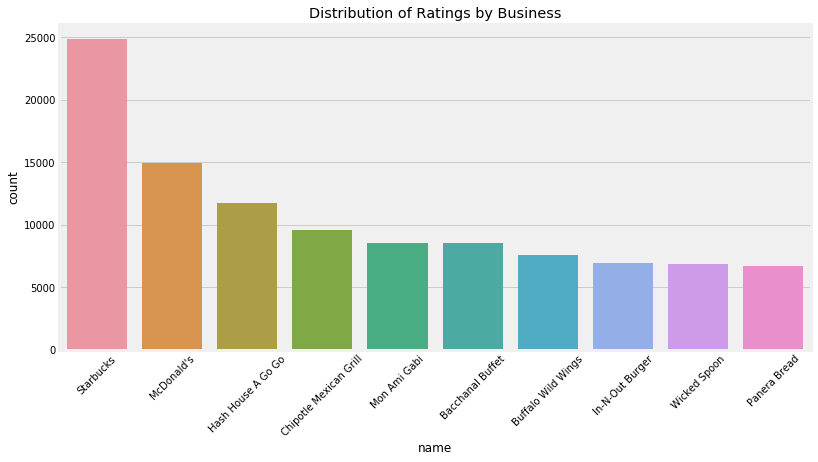

In [18]:
df = ratings.merge(businesses[['business_id', 'name']], on='business_id')
plt.figure(figsize=(12,6))

chart = sns.countplot(x='name',data=df, order=pd.value_counts(df['name']).iloc[:10].index)
chart.set(title='Distribution of Ratings by Business')
var = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

The distribution of ratings of active users indicate that while there are a small number of users who have reviewed around 4000 times (Maximum is 4129), the vast majority of the users have reviewed around 5 times.

In [19]:
user_counts[user_counts.values >= 5].describe()

count    286130.000000
mean         15.860874
std          32.607378
min           5.000000
25%           6.000000
50%           8.000000
75%          15.000000
max        4129.000000
Name: user_id, dtype: float64

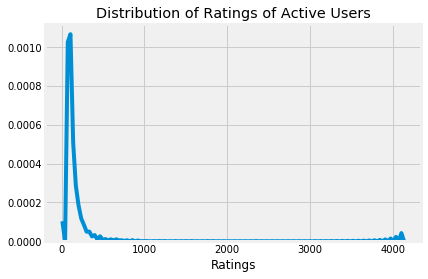

In [20]:
chart = sns.distplot(user_counts.values[user_counts.values > 15], norm_hist=True, hist=False, bins=5)
chart.set(title='Distribution of Ratings of Active Users', xlabel='Ratings');

# 3. Modeling <a class="anchor" id="3"></a>

## 3.0 Sampling Data

By identifying and filtering the users who gave 5 or more reviews, there are 286,130 active users and about 4.5 million ratings. Since we wanted to evaluate the performance on several models, we first sampled the active user data where there are 1000, 10,000, and 50,000 users (where 50,000 users account for approximately 17.5% of the entire data). For this given dataset, we wanted to sample by users to ensure that our sample dataset would contain an entire user-business interaction history of the sampled users. That way, it would align with our goal of predicting the last rating for each active user based on the entire user-business interaction history.

Furthermore, since users’ preference towards restaurants could gradually change over time, we believe that it would be reasonable to split our train and test data so that the train data would contain the earlier reviews, and the test data would consist of the latter reviews given by the users. That way, while we are supposedly predicting “future” reviews,  it is also consistent with our objective of predicting the final star rating (by date) given by the user. 
We also analyzed the categories for each business. As stated earlier, we decided to use the top-5 categories to feed into our model. This is because they account for approximately 70% of the businesses in our data.


In [21]:
active_user_only_ratings_df = ratings[ratings['user_id'].isin(active_users)]
len(active_user_only_ratings_df)

4538272

In [22]:
len(active_user_only_ratings_df['user_id'].unique())

286130

In [23]:
import datetime as dt

def get_sample_size_n(active_user_only_ratings_df, n): 
    sample_size = [n]

    for s in sample_size:
        sampleUID = active_user_only_ratings_df['user_id'].unique()[np.random.randint(active_user_only_ratings_df['user_id'].unique().shape[0], size=s)]
        active_user_only_ratings_df_sample = active_user_only_ratings_df[active_user_only_ratings_df['user_id'].isin(sampleUID)]
    
    active_user_only_ratings_df_sample['date'] = pd.to_datetime(active_user_only_ratings_df_sample['date'])

    # take 80% of reviews for each user sampled
    training_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[:round(len(x)*.8)]).reset_index(drop=True)

    # take 20% of reviews for each user sampled
    testing_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[round(len(x)*.8):]).reset_index(drop=True)
    
    return active_user_only_ratings_df_sample, training_data, testing_data

In [24]:
def print_df_info(n, total_df, training_df, testing_df):
    print('Total Number of Ratings: ', len(total_df))
    print('Total Number of Users: ', n)
    print("Training Size: ", len(training_df))
    print("Testing Size: ", len(testing_df))

In [25]:
sample_sizes = [1000, 10000, 50000]
active_user_only_ratings_df_sample, training_data, testing_data = get_sample_size_n(active_user_only_ratings_df, sample_sizes[0])
print_df_info(sample_sizes[0], active_user_only_ratings_df_sample, training_data, testing_data)

Total Number of Ratings:  16404
Total Number of Users:  1000
Training Size:  13144
Testing Size:  3260


In [26]:
active_user_only_ratings_df_sample2, training_data2, testing_data2 = get_sample_size_n(active_user_only_ratings_df, sample_sizes[1])
print_df_info(sample_sizes[1], active_user_only_ratings_df_sample2, training_data2, testing_data2)

Total Number of Ratings:  150722
Total Number of Users:  10000
Training Size:  120959
Testing Size:  29763


In [27]:
active_user_only_ratings_df_sample3, training_data3, testing_data3 = get_sample_size_n(active_user_only_ratings_df, sample_sizes[2])
print_df_info(sample_sizes[2], active_user_only_ratings_df_sample3, training_data3, testing_data3)

Total Number of Ratings:  725909
Total Number of Users:  50000
Training Size:  582297
Testing Size:  143612


In [28]:
all_samples = [active_user_only_ratings_df_sample, 
                  active_user_only_ratings_df_sample2, 
                  active_user_only_ratings_df_sample3]

all_training_samples = [training_data, training_data2, training_data3]

all_testing_samples = [testing_data, testing_data2, testing_data3]

## 3.1 Baseline Model: Learned Bias <a class="anchor" id="3-1"></a>

Our first baseline model is learned bias, where for each user and business pair, we take the user's average rating and the business's average rating and take their mean to get a predicted rating. 

In [29]:
def find_average_user_ratings(ratings_df):
    ratings_series = ratings_df.groupby('user_id')['rating'].mean()
    return pd.DataFrame({'user_id':ratings_series.index, 'avg_user_rating':ratings_series.values})


In [30]:
def find_average_business_ratings(ratings_df):    
    ratings_series = ratings_df.groupby('business_id')['rating'].mean()
    return pd.DataFrame({'business_id':ratings_series.index, 'avg_business_rating':ratings_series.values})


In [31]:
def predict_learned_bias(df, average_user_ratings, average_business_ratings, missingVal=3.0):
    
    baseline_line_predictions = df.merge(average_user_ratings, how ='left', on='user_id')
    baseline_line_predictions = baseline_line_predictions.merge(average_business_ratings, how ='left', on='business_id')
    baseline_line_predictions['avg_business_rating'] = baseline_line_predictions['avg_business_rating'].fillna(value=missingVal)
    baseline_line_predictions['avg_user_rating'] = baseline_line_predictions['avg_user_rating'].astype(float)
    baseline_line_predictions['avg_business_rating'] = baseline_line_predictions['avg_business_rating'].astype(float)
    baseline_line_predictions['predicted_rating'] = (baseline_line_predictions['avg_user_rating'] + baseline_line_predictions['avg_business_rating']) / 2
    
    return baseline_line_predictions

In [32]:
def calculate_catalog_coverage(ratingsDict, N, k=3, pred_col_name='predicted_rating'):
    '''
    k: top k businesses
    N: total number of businesses
    '''
    
    recList = []
    for keys in ratingsDict.keys():
        
        if k >= len(ratingsDict[keys]):
            for row in ratingsDict[keys]:
                recList.append(row['business_id'])
        else:
            for index, item in enumerate(sorted(ratingsDict[keys], key=lambda x: -x[pred_col_name])):
                if index+1 <= k:
                    recList.append(item['business_id'])
                else:
                    pass

    recommended_set = set(recList)

    coverage = (len(recommended_set) / N) * 100
    print('Catalog Coverage: {}%'.format(coverage))
    return coverage

In [33]:
def run_baseline_model(X_data, y_data):
    average_user_ratings = find_average_user_ratings(X_data)
    average_business_ratings = find_average_business_ratings(X_data)
     
    baseline_line_predictions_test = predict_learned_bias(y_data, average_user_ratings, average_business_ratings)
    
    N = len(baseline_line_predictions_test)
    baseline_rmse_test = np.sum(np.sqrt(((baseline_line_predictions_test['predicted_rating'] - baseline_line_predictions_test['rating']) / N) ** 2))
    
    baseline_line_predictions_dict = dict(baseline_line_predictions_test.set_index('user_id').groupby(level = 0).apply(lambda x : x.to_dict(orient= 'records')))
    N = len(baseline_line_predictions_test['business_id'].unique())
    coverage = calculate_catalog_coverage(baseline_line_predictions_dict, N, k=5)

    return baseline_rmse_test, coverage, baseline_line_predictions_test

In [34]:
rmse, coverage, baseline_predictions = run_baseline_model(training_data, testing_data)

Catalog Coverage: 69.65493910690121%


In [35]:
rmse, coverage 

(1.1790384113004118, 69.65493910690121)

In [36]:
rmse2, coverage2, baseline_predictions2 = run_baseline_model(training_data2, testing_data2)

Catalog Coverage: 75.10193933366484%


In [37]:
rmse2, coverage2

(1.084912746514116, 75.10193933366484)

In [38]:
rmse3, coverage3, baseline_predictions3 = run_baseline_model(training_data3, testing_data3)

Catalog Coverage: 80.38108553810855%


In [39]:
rmse3, coverage3

(1.0360132065826084, 80.38108553810855)

### 3.1.1 Accuracy of Learned Bias Model<a class="anchor" id="3-1-1"></a>

We look at RMSE as a measure of accuracy. The first RMSE is for the sample with 1000 users, the second is for 10000 users and the third is when we sampled 50000 users. We can see that as the sample size increased, the RMSE improved (decreased).

In [40]:
baseline_rmses = [rmse, rmse2, rmse3]
baseline_rmses

[1.1790384113004118, 1.084912746514116, 1.0360132065826084]

### 3.1.2 Coverage of Learned Bias Model<a class="anchor" id="3-1-2"></a>

We additionally looked at catalog coverage. The first catalog coverage is for the sample with 1000 users, the second is for 10000 users and the third is when we sampled 50000 users. We can see that as the sample size increased, the catalog coverage improved (increased).

In [41]:
baseline_coverages = [coverage, coverage2, coverage3]
baseline_coverages

[69.65493910690121, 75.10193933366484, 80.38108553810855]

### 3.2 Baseline Model: Vanilla Matrix Factorization <a class="anchor" id="3-2"></a>

As a second baseline model, we used vanilla matrix factorization 

In [42]:
from pyspark.mllib.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.tuning import (CrossValidator, ParamGridBuilder)

import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Load ratings data into PySpark dataframe
data_schema = StructType([
    StructField('numeric_user_id', IntegerType(), False),
    StructField('numeric_business_id', IntegerType(), False),
    StructField('rating',FloatType(), False)])

#Spark Session
spark =SparkSession.builder.appName('ALS').getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)


In [43]:
all_sample_dfs = [active_user_only_ratings_df_sample, active_user_only_ratings_df_sample2, active_user_only_ratings_df_sample3]
all_training_dfs = [training_data, training_data2, training_data3]
all_testing_dfs = [testing_data, testing_data2, testing_data3]


for df in [all_training_dfs, all_testing_dfs]:
    for train in df:
        numeric_user_id_dict = {key: value + 1 for value, key in enumerate(train['user_id'].unique())}
        numeric_business_id_dict = {key: value + 1 for value, key in enumerate(train['business_id'].unique())}

        train['numeric_user_id'] = train['user_id'].apply(lambda u: numeric_user_id_dict[u])
        train['numeric_business_id'] = train['business_id'].apply(lambda b: numeric_business_id_dict[b])

In [44]:
# Create Spark DF from Pandas DF
all_sample_spark_dfs_train = []
all_sample_spark_dfs_test = []

for sample_df in all_training_dfs:
    new_sample_df = sample_df[['numeric_user_id', 'numeric_business_id', 'rating']]
    spark_sample_df = spark.createDataFrame(new_sample_df, schema=data_schema)
    all_sample_spark_dfs_train.append(spark_sample_df)

for sample_df in all_testing_dfs:
    new_sample_df = sample_df[['numeric_user_id', 'numeric_business_id', 'rating']]
    spark_sample_df = spark.createDataFrame(new_sample_df, schema=data_schema)
    all_sample_spark_dfs_test.append(spark_sample_df)

In [45]:
def plot_rmse_vs_param(cvModels, param_list, xlabel):
    plt.figure(figsize=(10, 6))
    for cvModel in cvModels: 
        plt.plot(param_list, cvModel.avgMetrics, marker='o')

    plt.xlabel(xlabel)
    plt.ylabel('RMSE')
    plt.title('RMSE vs {} by Number of Active Users'.format(xlabel))
    plt.legend(['{} Active Users'.format(n) for n in sample_sizes])
    plt.grid(True)
    plt.show()

### 3.2.1 Tuning Hyperparameters  <a class="anchor" id="3-2-1"></a>

**Regularization Parameter**

In [46]:
als = ALS(maxIter=5, userCol="numeric_user_id", itemCol="numeric_business_id", ratingCol="rating",
              coldStartStrategy="drop", nonnegative= True)

reg_list = [0.001, 0.1, 0.2]
paramGrid = ParamGridBuilder().addGrid(als.regParam, reg_list).build()
    
crossval = CrossValidator(estimator=als,
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(metricName="rmse",
                                                            labelCol="rating"),
                              numFolds=3)

cvs = []
for i in range(3):
    cv = crossval.fit(all_sample_spark_dfs_train[i])
    cvs.append(cv)
    print('RMSEs (tuning RegParam):', cv.avgMetrics)

RMSEs (tuning RegParam): [3.182061397411228, 2.0441366702852806, 1.987522157706846]
RMSEs (tuning RegParam): [3.8560588923231442, 1.7424215836149237, 1.655989164770081]
RMSEs (tuning RegParam): [3.612037802588028, 1.5457387527610602, 1.4780722464985914]


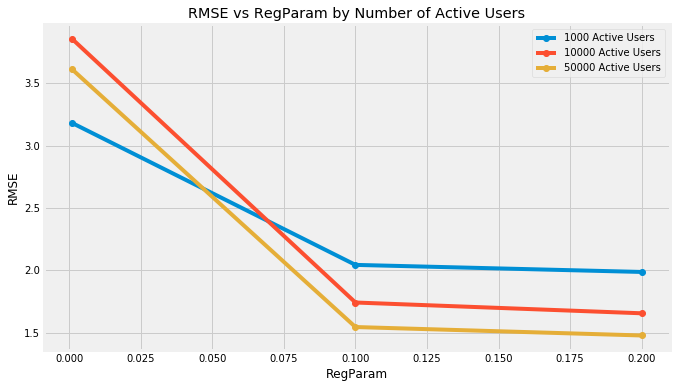

In [47]:
plot_rmse_vs_param(cvs, reg_list, 'RegParam')

In [48]:
best_reg = 0.2

**Rank**

In [49]:
import time

als = ALS(regParam=best_reg, maxIter=5, userCol="numeric_user_id", itemCol="numeric_business_id", ratingCol="rating",
          coldStartStrategy="drop", nonnegative= True)

rank_list = [5, 10, 20]
paramGrid = ParamGridBuilder().addGrid(als.rank, rank_list).build()
crossval_rank = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse",
                                                        labelCol="rating"),
                          numFolds=3)

cv_ranks = []
for i in range(3):
    start = time.time()
    cv_rank = crossval_rank.fit(all_sample_spark_dfs_train[i])
    cv_ranks.append(cv_rank)
    end = time.time()
    print('RMSEs (tuning Rank):', cv_rank.avgMetrics, 'Time: ', end - start)

RMSEs (tuning Rank): [1.9795415279380575, 1.9875221577068463, 2.0196830374919377] Time:  54.69717979431152
RMSEs (tuning Rank): [1.6467891256719405, 1.655989164770081, 1.654779850719891] Time:  134.6790840625763
RMSEs (tuning Rank): [1.4729708803070627, 1.4780722464985914, 1.4775676566107976] Time:  229.45668387413025


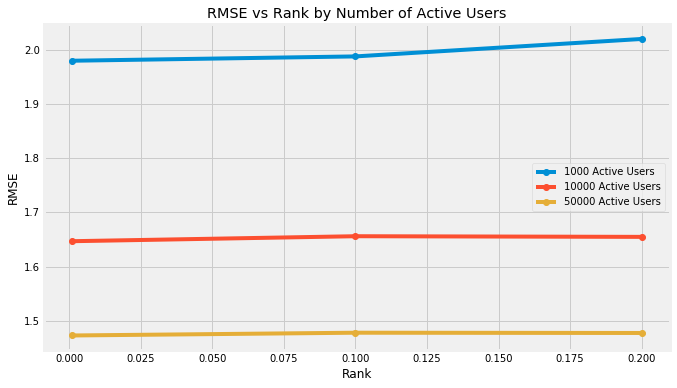

In [50]:
plot_rmse_vs_param(cv_ranks, reg_list, 'Rank')

In [51]:
best_rank = 20

In [52]:
# Final model
als = ALS(regParam=best_reg, rank=best_rank, maxIter=5, userCol="numeric_user_id", itemCol="numeric_business_id", ratingCol="rating",
          coldStartStrategy="drop", nonnegative= True)


final_models = []
for i in range(3):
    final_model = als.fit(all_sample_spark_dfs_train[i])
    final_models.append(final_model)

### 3.2.2 Accuracy of Vanilla Matrix Factorization  <a class="anchor" id="3-2-2"></a>

In [53]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

final_rmses = []
final_predictions_tests = []
for i in range(3):
    final_predictions_test = final_model.transform(all_sample_spark_dfs_test[i])
    final_predictions_tests.append(final_predictions_test)
    
    final_rmse = evaluator.evaluate(final_predictions_test)
    final_rmses.append(final_rmse)
    
    print('RMSEs (after tuning):', final_rmse)

RMSEs (after tuning): 1.888621491292947
RMSEs (after tuning): 1.8714080111560851
RMSEs (after tuning): 1.7314241587469161


In [54]:
baseline_MF_rmses = final_rmses

### 3.2.3 Coverage of Vanilla Matrix Factorization  <a class="anchor" id="3-2-3"></a>

In [55]:
als_catalog_coverages = []
for spark_test_df in final_predictions_tests:
    pandas_test_df = spark_test_df.toPandas()
    pandas_test_df.rename(columns={"numeric_user_id": "user_id", 'numeric_business_id': 'business_id'}, inplace=True)
    pandas_test_df.sort_values(by=['user_id', 'rating'])
    ratings_dictionary = dict(pandas_test_df.set_index('user_id').groupby(level = 0).apply(lambda x : x.to_dict(orient= 'records')))
    N = len(pandas_test_df['business_id'].unique())    
    als_catalog_coverages.append(calculate_catalog_coverage(ratings_dictionary, N, pred_col_name='prediction'))
    

Catalog Coverage: 59.67523680649527%
Catalog Coverage: 66.9617105917454%
Catalog Coverage: 73.29174732917473%


## 3.3 SVD and Nonnegative Matrix Factorization <a class="anchor" id="3-3"></a>

In [56]:
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise.model_selection.validation import cross_validate
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split as s_train_test_split
from surprise.model_selection import KFold
from surprise import Reader

In [57]:
def create_result_df(predictions):
    predictions_list = []
    for i in range(len(predictions)):
        predictions_list.append(list(predictions[i][:-1]))
        
    return pd.DataFrame(predictions_list, columns = ['user_id', 'business_id', 'rating', 'predicted'])

In [58]:
all_mf_prediction_dfs = []
all_benchmark_dfs = []

mf_algo_dict = {'SVD': 0, 'NMF': 1, 'SVD++': 2}
all_mf_coverages = {mf_algo_dict['SVD']: [], mf_algo_dict['NMF']: [], mf_algo_dict['SVD++']: []}
all_mf_rmses = {mf_algo_dict['SVD']: [], mf_algo_dict['NMF']: [], mf_algo_dict['SVD++']: []}

MF_algorithms = [SVD(), NMF()]
# MF_algorithms = [SVD(), NMF(), SVDpp()]


for i in range(len(all_training_samples)):
    training_sample = all_training_samples[i]
    testing_sample = all_testing_samples[i]
    
    reader = Reader(rating_scale=(1.0, 5.0))
    
    train_df = Dataset.load_from_df(training_sample[['user_id', 'business_id', 'rating']], reader)
    test_df = Dataset.load_from_df(testing_sample[['user_id', 'business_id', 'rating']], reader)

    benchmark = []
    prediction_dfs = []

    for j in range(len(MF_algorithms)):
        algorithm = MF_algorithms[j]
        # cross validation
        # measures available: RMSE, MAE
        # cv: determines how the train & test is split: 3-fold 
        # If verbose = True: accuracy measures for each split are printed, as well as train and test times
        results = cross_validate(algorithm, test_df, measures=['RMSE'], cv=3, return_train_measures=True,verbose=False)
        algorithm.fit(train_df.build_full_trainset())
        predictions_test = algorithm.test(test_df.build_full_trainset().build_testset())
        rmse = accuracy.rmse(predictions_test)
        
        # save predictions 
        prediction_df = create_result_df(predictions_test)
        prediction_dfs.append(prediction_df)
        all_mf_prediction_dfs.append(prediction_dfs)

        # Get results & algorithm
        tmp = pd.DataFrame.from_dict(results).mean(axis=0) #test_rmse, fit_time, test_time    
        print(tmp)
        tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
        benchmark.append(tmp)

        # save rmses
        all_mf_rmses[j].append(rmse)
        
        # save coverages
        predictions_dict = dict(prediction_df.set_index('user_id').groupby(level = 0).apply(lambda x : x.to_dict(orient= 'records')))
        N = len(prediction_df['business_id'].unique())
        coverage = calculate_catalog_coverage(predictions_dict, N, k=5, pred_col_name='predicted')
        all_mf_coverages[j].append(coverage)

    # save RMSEs
    benchmark_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  
    all_benchmark_dfs.append(benchmark_df)

    

RMSE: 1.3300
test_rmse     1.376487
train_rmse    0.927012
fit_time      0.167469
test_time     0.009678
dtype: float64
Catalog Coverage: 70.09472259810555%
RMSE: 1.4679
test_rmse     1.439888
train_rmse    0.231915
fit_time      0.369497
test_time     0.008066
dtype: float64
Catalog Coverage: 69.89174560216509%
RMSE: 1.2969
test_rmse     1.360029
train_rmse    0.916481
fit_time      1.425921
test_time     0.074692
dtype: float64
Catalog Coverage: 75.05718547986076%
RMSE: 1.4579
test_rmse     1.491098
train_rmse    0.218256
fit_time      3.049628
test_time     0.067269
dtype: float64
Catalog Coverage: 75.61909497762306%
RMSE: 1.2699
test_rmse     1.334221
train_rmse    0.908531
fit_time      7.496847
test_time     0.511887
dtype: float64
Catalog Coverage: 79.4507779450778%
RMSE: 1.4108
test_rmse      1.516199
train_rmse     0.197688
fit_time      14.670921
test_time      0.371674
dtype: float64
Catalog Coverage: 80.2753280275328%


In [59]:
all_mf_rmses

{0: [1.3300349516841978, 1.2968613438218224, 1.269869370220067],
 1: [1.4678744693057757, 1.4579039995055583, 1.410763512160192],
 2: []}

In [60]:
all_mf_coverages

{0: [70.09472259810555, 75.05718547986076, 79.4507779450778],
 1: [69.89174560216509, 75.61909497762306, 80.2753280275328],
 2: []}

## 3.4 Wide and Deep Model <a class="anchor" id="3-4"></a>

In this model a wide linear model and deep neural network are jointly trained to combine the benefits of memorization and generalization for recommender systems. Wide linear models can effectively memorize sparse feature interactions using cross-product feature transformations, while deep neural networks can generalize previously unseen feature interactions through low-dimensional embeddings.

### 3.4.1 Feature Selection <a class="anchor" id="3-4-1"></a>

A set of relevant features are selected from the original dataset to be used for training the model. We notice that the dataset is highly imbalanced hence we perform oversampling ( Up-sampling) to create a balanced dataset for the traning data only.

In [61]:
def create_features(active_user_only_ratings_df_sample):
    base_df = active_user_only_ratings_df_sample

    #sparse alert - hopefully with bigger dataset, we will see some weird ratings..
    real_average = base_df[['business_id','rating']].groupby('business_id').mean().reset_index()
    real_average.rename(columns={"rating": "average_business_rating"}, inplace=True)

    #Average ratings for business added
    base_df = base_df.merge(real_average, how='left', on='business_id')

    #one-hot encoding for top5 categories
    catList = []
    businesses['categories'].fillna(value='',inplace=True)
    businesses['cat'] = businesses['categories'].apply(lambda x: x.split(','))
    catList.extend(businesses['cat'])
    merged = [x.strip() for x in list(itertools.chain(*catList))]

    #Adding state, review_count, is_open
    base_df = base_df.merge(businesses[['business_id','state','city', 'latitude', 'longitude','review_count','is_open', 'hours', 'cat']], on='business_id')
    base_df.rename(columns={"review_count": "business_review_count"}, inplace=True)

    #getting top 5 common categories items
    top5List = [x for x in list(itertools.chain(*Counter(merged).most_common(5))) if type(x) != int]

    #one-hot encoding if the business in top 5 common category
    for item in top5List:
        base_df[item] = base_df['cat'].apply(lambda categories: 'Y' if bool(set([y.strip() for y in categories]).intersection([item])) else 'N')
        #base_df[item] = base_df['cat'].apply(lambda categories: 'Y' if bool(set([y.strip() for y in categories]).intersection(set(item))) else 'N')

    # is_open (categorical) change from 1 and 0 to Y and N
    base_df['is_open'] = base_df['is_open'].apply(lambda x: 'Y' if x else 'N')

    # hours: how many days per week it's open
    base_df['hours'] = base_df['hours'].apply(lambda x: len(x.keys()) if x else 0)
    base_df.rename(columns={"hours": "days_per_week_open"}, inplace=True)

    # user information
    base_df = base_df.merge(users[['user_id', 'average_stars', 'review_count', 'friends']],  on='user_id')

    # number_of_friends
    base_df['friends'] = base_df['friends'].apply(lambda x: len(x.split(',')))
    base_df.rename(columns={"friends": "number_of_friends", "review_count": "user_review_count", "average_stars": "average_user_rating"}, inplace=True)

    #number of tips for popularity measure of business
    business_numberOfTips = tips[['business_id','user_id']].groupby('business_id').count().reset_index()
    business_numberOfTips.rename(columns={"user_id": "business_numberOfTips"}, inplace=True)
    base_df = base_df.merge(business_numberOfTips, on='business_id')

    #number of photo for popularity measure of business
    business_numberOfPhotos = photos[['business_id','photo_id']].groupby('business_id').count().reset_index()
    business_numberOfPhotos.rename(columns={"photo_id": "business_numberOfPhotos"}, inplace=True)
    base_df = base_df.merge(business_numberOfPhotos, on='business_id')
    
    return base_df

In [62]:
training_features = create_features(training_data)
testing_features = create_features(testing_data)

In [63]:
training_features2 = create_features(training_data2)
testing_features2 = create_features(testing_data2)

In [64]:
training_features3 = create_features(training_data3)
testing_features3 = create_features(testing_data3)

In [65]:
training_features3.columns

Index(['user_id', 'business_id', 'rating', 'date', 'numeric_user_id',
       'numeric_business_id', 'average_business_rating', 'state', 'city',
       'latitude', 'longitude', 'business_review_count', 'is_open',
       'days_per_week_open', 'cat', 'Restaurants', 'Shopping', 'Food',
       'Home Services', 'Beauty & Spas', 'average_user_rating',
       'user_review_count', 'number_of_friends', 'business_numberOfTips',
       'business_numberOfPhotos'],
      dtype='object')

In [66]:
train_nn = training_features3[['user_id','business_id','average_business_rating','state','city','latitude','longitude',
                           'business_review_count','days_per_week_open','Restaurants','Shopping','Food','Home Services',
                            'Beauty & Spas','average_user_rating','user_review_count','business_numberOfPhotos', 'rating']]

train_nn= train_nn.rename(columns= {'Home Services': 'Home_Services', 'Beauty & Spas': 'Beauty_and_Spas'})

In [67]:
labels = train_nn.pop('rating')

In [68]:
class1 = np.where(labels==1)[0]
class2= np.where(labels==2)[0]
class3 = np.where(labels==3)[0]
class4= np.where(labels==4)[0]
class5 = np.where(labels==5)[0]

class1_upsampled = np.random.choice(class1, size = 100000, replace= True)
class2_upsampled = np.random.choice(class2, size = 100000, replace= True)
class3_upsampled = np.random.choice(class3, size = 100000, replace= True)
class4_upsampled = np.random.choice(class4, size = 100000, replace= True)

train_nn_1 = train_nn.iloc[class1_upsampled]
train_nn_2 = train_nn.iloc[class2_upsampled]
train_nn_3 = train_nn.iloc[class3_upsampled]
train_nn_4 = train_nn.iloc[class4_upsampled]
train_nn_5 = train_nn.iloc[class5]

labels_1 = labels.iloc[class1_upsampled]
labels_2 = labels.iloc[class2_upsampled]
labels_3 = labels.iloc[class3_upsampled]
labels_4 = labels.iloc[class4_upsampled]
labels_5 = labels.iloc[class5]

train_nn_balanced = train_nn_1
train_nn_balanced = train_nn_balanced.append(train_nn_2, ignore_index = True)
train_nn_balanced= train_nn_balanced.append(train_nn_3, ignore_index = True)
train_nn_balanced= train_nn_balanced.append(train_nn_4, ignore_index = True)
train_nn_balanced= train_nn_balanced.append(train_nn_5, ignore_index = True)

labels_balanced = labels_1
labels_balanced = labels_balanced.append(labels_2, ignore_index = True)
labels_balanced = labels_balanced.append(labels_3, ignore_index = True)
labels_balanced = labels_balanced.append(labels_4, ignore_index = True)
labels_balanced = labels_balanced.append(labels_5, ignore_index = True)

In [69]:
assert len(train_nn_balanced) == len(labels_balanced)

In [70]:
train_nn = train_nn_balanced
labels = labels_balanced

train_nn.head()

,user_id,business_id,average_business_rating,state,city,latitude,longitude,business_review_count,days_per_week_open,Restaurants,Shopping,Food,Home_Services,Beauty_and_Spas,average_user_rating,user_review_count,business_numberOfPhotos
0,9MAN39lsFciXRLMZ0_jDYQ,fgrMJzwI-AcdvhNZgFCgvw,3.200,NV,Henderson,36.063284,-115.046862,68,7,Y,N,N,N,N,2.00,5,2
1,X6RLuqHTInbdfhke6yC0TQ,WKs7BvLVGrXbjVbzHey6kw,2.900,NV,North Las Vegas,36.240446,-115.116300,139,6,Y,N,N,N,N,2.70,9,5
2,ScwVhHmUFLZwVW9E5fvKjw,OPSNdO3LNPMt7qz1MNb42g,3.520,NV,Las Vegas,36.118909,-115.154332,681,0,Y,N,Y,N,N,3.55,72,38
3,_ZPWsEDaH5492T5YQ0eGXA,8QYOnNLFTrpfPip44eMheg,3.650,AZ,Gilbert,33.334549,-111.804860,146,7,Y,N,N,N,N,4.11,43,1
4,HVOA8lVvoZBUibJe743uQQ,7ibuDLfx8gEhESAufYIySw,3.872,NV,Las Vegas,36.011732,-115.135982,1051,7,Y,N,N,N,N,4.13,66,39


In [71]:
labels = labels.apply(lambda x: int(x)-1)
test_nn = testing_features3[['user_id','business_id','average_business_rating','state','city','latitude','longitude',
                           'business_review_count','days_per_week_open','Restaurants','Shopping','Food','Home Services',
                            'Beauty & Spas','average_user_rating','user_review_count','business_numberOfPhotos', 'rating']]

test_nn= test_nn.rename(columns= {'Home Services': 'Home_Services', 'Beauty & Spas': 'Beauty_and_Spas'})
test_nn['rating']= test_nn['rating'].apply(lambda x: int(x)-1)
test_labels = test_nn.pop('rating')

### 3.4.2 Feature Engineering  <a class="anchor" id="3-4-2"></a>

For the wide component the feature set includes raw input features and transformed features. The sparse features are one hot encoded and cross product transformation was implemented on certain features. This captures the interaction between binary features and adds non-linearity to the generalized linear model.

For the deep component each of the sparse high dimensional categorical features are first converted into low dimensional and dense real valued vector with the help of embeddings.


In [130]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import feature_column
from tensorflow.keras import layers

In [116]:
numeric_features = ['average_business_rating','business_review_count','average_user_rating',
                    'user_review_count', 'days_per_week_open','business_numberOfPhotos','latitude','longitude']
cat_features = ['user_id','business_id','state','city','Restaurants','Shopping','Food',
                'Home_Services', 'Beauty_and_Spas']

#continuous features
cont = {
        colname : feature_column.numeric_column(colname) for colname in numeric_features
}

#categorical features
cat = {
        'user_id' : feature_column.categorical_column_with_hash_bucket('user_id', hash_bucket_size=10000),
        'business_id' : feature_column.categorical_column_with_hash_bucket('business_id', hash_bucket_size=10000),
        'state' : feature_column.categorical_column_with_hash_bucket('state', hash_bucket_size=1000),
        'city' : feature_column.categorical_column_with_hash_bucket('city', hash_bucket_size=1000),
        'Restaurants' : feature_column.categorical_column_with_vocabulary_list('Restaurants', ['Y', 'N'], default_value = 0),
        'Shopping' : feature_column.categorical_column_with_vocabulary_list('Shopping', ['Y', 'N'], default_value = 0),
        'Food' : feature_column.categorical_column_with_vocabulary_list('Food', ['Y', 'N'], default_value = 0),
        'Home_Services' : feature_column.categorical_column_with_vocabulary_list('Home_Services', ['Y', 'N'], default_value = 0),
        'Beauty_and_Spas' : feature_column.categorical_column_with_vocabulary_list('Beauty_and_Spas', ['Y', 'N'], default_value = 0)
}

In [117]:
#embed sparse columns for dense layer
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, 10)
          for colname, col in cat.items()
}

#columns for dense network
dense = cont.copy()
dense.update(embed)

In [118]:
#one hot encode sparse columns for wide network
wide = {
    'ohe_{}'.format(colname)  : tf.feature_column.indicator_column(col)
          for colname, col in cat.items()
}

#crossed columns
lat_boundary = list(train_nn.latitude.sort_values().unique())
long_boundary = list(train_nn.longitude.sort_values().unique())

latitude_bucket_fc = feature_column.bucketized_column(cont.get('latitude'), lat_boundary)
longitude_bucket_fc = feature_column.bucketized_column(cont.get('longitude'), long_boundary)

#crossed_lat_lon = feature_column.crossed_column([latitude_bucket_fc, longitude_bucket_fc], 5000)
wide['crossed_lat_lon'] = feature_column.crossed_column([latitude_bucket_fc, longitude_bucket_fc], 5000)
#print(wide.keys())

In [119]:
def df_to_dataset_train(dataframe, labels,  shuffle = True, batch_size = 32):
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds


In [120]:
def df_to_dataset_eval(dataframe, labels, batch_size= 32):
    if labels is None:
        ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    else:
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.batch(batch_size)
    return ds

In [121]:
list(wide.keys())

['ohe_user_id',
 'ohe_business_id',
 'ohe_state',
 'ohe_city',
 'ohe_Restaurants',
 'ohe_Shopping',
 'ohe_Food',
 'ohe_Home_Services',
 'ohe_Beauty_and_Spas',
 'crossed_lat_lon']

In [122]:
list(dense.keys())

['average_business_rating',
 'business_review_count',
 'average_user_rating',
 'user_review_count',
 'days_per_week_open',
 'business_numberOfPhotos',
 'latitude',
 'longitude',
 'embed_user_id',
 'embed_business_id',
 'embed_state',
 'embed_city',
 'embed_Restaurants',
 'embed_Shopping',
 'embed_Food',
 'embed_Home_Services',
 'embed_Beauty_and_Spas']

### 3.4.3 Modeling <a class="anchor" id="3-4-3"></a>

The wide component consists of a generalized linear model and the deep component is a feed forward neural network. The wide and deep component are combined using a weighted sum of their output log odds at the prediction which is then fed into a common logistic loss function during training.

Joint training is done by back-propagating the gradients from the output to both wide and deep part of the model using stochastic mini batch descent. The regularizers and optimizer parameters were set to the values used in the paper 'Wide and Deep Learning for Recommender Systems'. The number of hidden units were tuned.

In [131]:
estimator = tf.estimator.DNNLinearCombinedClassifier(
    # wide settings
    linear_feature_columns=list(wide.values()),
    linear_optimizer='Ftrl',
    # deep settings
    dnn_feature_columns=list(dense.values()),
    dnn_hidden_units=[1000, 500, 100],
#     dnn_optimizer=tf.train.ProximalAdagradOptimizer(learning_rate = 0.1),
    n_classes = 5)

In [124]:
# To apply L1 and L2 regularization, you can set dnn_optimizer to:
# tf.train.ProximalAdagradOptimizer(
#     learning_rate=0.1,
#     l1_regularization_strength=0.001,
#     l2_regularization_strength=0.001)

# To apply learning rate decay, you can set dnn_optimizer to a callable:
# lambda: tf.AdamOptimizer(
#     learning_rate=tf.exponential_decay(
#         learning_rate=0.1,
#         global_step=tf.get_global_step(),
#         decay_steps=10000,
#         decay_rate=0.96))

In [82]:
def input_fn_train():
    return df_to_dataset_train(train_nn, labels)

In [83]:
def input_fn_eval():
    return df_to_dataset_eval(test_nn, test_labels)

In [84]:
def input_fn_pred():
    return df_to_dataset_eval(test_nn)

In [132]:
estimator.train(input_fn=input_fn_train, steps=100)

In [133]:
results = estimator.evaluate(input_fn=input_fn_eval, steps = 100)

## 3.4.4 Accuracy <a class="anchor" id="3-4-4"></a>

We notice that our model does not outperform the baseline model. This could be due to several reasons. The deep component of the model can be improved in several ways. We can include droput, change the optimizers to find the best parameters that fit our model. The highly imbalanced dataset also affects the accuracy of the test set. Other metrics can be used to better represent the results. 

In [87]:
for key in sorted(results):
    print( "%s: %s" % (key, results[key]))

accuracy: 0.080625
average_loss: 11.883461
global_step: 100
loss: 11.883461


In [134]:
predictor = estimator.predict( input_fn = input_fn_eval)

In [135]:
pred = list(predictor)
len(pred), len(test_labels)

(77191, 77191)

In [136]:
prededictions = [val['class_ids'][0] + 1 for val in pred]

In [137]:
prededictions_df = test_nn[['user_id', 'business_id']]
prededictions_df['rating'] = test_labels + 1
prededictions_df['predicted_rating'] = prededictions

In [138]:
predictions_size = len(prededictions_df)
rmse_wd = (sum( (prededictions_df['rating'] - prededictions_df['predicted_rating']) ** 2 ) / predictions_size) ** 0.5

In [139]:
rmse_wd

2.5971679163331833

## 3.4.5 Coverage <a class="anchor" id="3-4-5"></a>

In [94]:
prededictions_wd_dict = dict(prededictions_df.set_index('user_id').groupby(level = 0).apply(lambda x : x.to_dict(orient= 'records')))
N = len(prededictions_df['business_id'].unique())
coverage_wd = calculate_catalog_coverage(prededictions_wd_dict, N, k=5)

Catalog Coverage: 87.98264403800736%


# 4. Evaluation <a class="anchor" id="4"></a>

## 4.1 Accuracy <a class="anchor" id="4-1"></a>

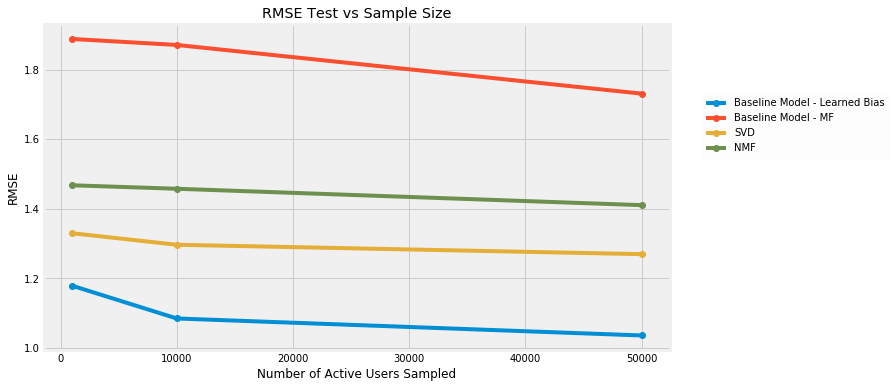

In [114]:
LEGEND = ['Baseline Model - Learned Bias', 'Baseline Model - MF', 'SVD', 'NMF', 'Wide and Deep']

plt.figure(figsize=(10, 6))

plt.plot(sample_sizes, baseline_rmses, marker='o')
plt.plot(sample_sizes, baseline_MF_rmses, marker='o')
plt.plot(sample_sizes, all_mf_rmses[0], marker='o')
plt.plot(sample_sizes, all_mf_rmses[1], marker='o')

plt.xlabel('Number of Active Users Sampled')
plt.ylabel('RMSE')
plt.title('RMSE Test vs Sample Size')
plt.legend(LEGEND, loc='upper center', bbox_to_anchor=(1.2, 0.8), ncol=1,fancybox=True, framealpha=0.1)
plt.grid(True)
plt.show()

## 4.2 Coverage <a class="anchor" id="4-2"></a>

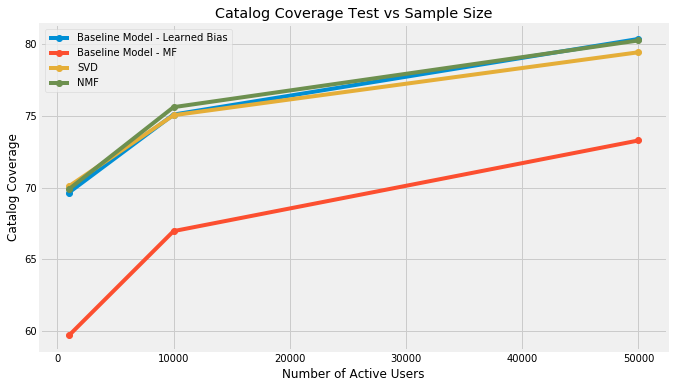

In [108]:
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, baseline_coverages, marker='o')
plt.plot(sample_sizes, als_catalog_coverages, marker='o')
plt.plot(sample_sizes, all_mf_coverages[0], marker='o')
plt.plot(sample_sizes, all_mf_coverages[1], marker='o')

plt.xlabel('Number of Active Users')
plt.ylabel('Catalog Coverage')
plt.title('Catalog Coverage Test vs Sample Size')
plt.legend(LEGEND)
plt.grid(True)
plt.show()

## 4.3 Hold Out <a class="anchor" id="4-3"></a>

In [97]:
def calculate_rmse(df, predicted_col='predicted_rating', rating_col='rating'):
    return np.sqrt( sum( (df[predicted_col] - df[rating_col]) ** 2  / len(df) ))

In [98]:
bs_hold_outs = baseline_predictions3.sort_values(by=['user_id']).groupby('user_id').apply(lambda x: x[-1:]).reset_index(drop=True)
rmse_bs_hold_out = calculate_rmse(bs_hold_outs)

als_predicted = final_predictions_tests[-1].toPandas()
als_hold_outs = als_predicted.sort_values(by=['numeric_user_id']).groupby('numeric_user_id').apply(lambda x: x[-1:]).reset_index(drop=True)
rmse_als_hold_out = calculate_rmse(als_hold_outs, predicted_col='prediction', rating_col='rating')

svd_hold_outs = prediction_dfs[0].sort_values(by=['user_id']).groupby('user_id').apply(lambda x: x[-1:]).reset_index(drop=True)
rmse_svd_hold_out = calculate_rmse(svd_hold_outs, predicted_col='predicted', rating_col='rating')

nmf_hold_outs = prediction_dfs[1].sort_values(by=['user_id']).groupby('user_id').apply(lambda x: x[-1:]).reset_index(drop=True)
rmse_nmf_hold_out = calculate_rmse(nmf_hold_outs, predicted_col='predicted', rating_col='rating')

wd_hold_outs = prededictions_df.sort_values(by=['user_id']).groupby('user_id').apply(lambda x: x[-1:]).reset_index(drop=True)
rmse_wd_hold_out = calculate_rmse(wd_hold_outs)

In [99]:
holds_outs = pd.DataFrame({'Baseline Model - Learned Bias': rmse_bs_hold_out, 
                           'Baseline Model - MF': rmse_als_hold_out,
                           'SVD': rmse_svd_hold_out, 
                           'NMF': rmse_nmf_hold_out, 
                           'Wide and Deep': rmse_wd_hold_out}, 
                          index=['RMSE'])

holds_outs

,Baseline Model - Learned Bias,Baseline Model - MF,SVD,NMF,Wide and Deep
RMSE,1.368302,1.848548,1.365759,1.519074,2.411925


## Final Results Table

In [100]:
all_rmses = [baseline_rmses, baseline_MF_rmses, all_mf_rmses[0], all_mf_rmses[1]]
all_rmses = [rmses[-1] for rmses in all_rmses]
all_rmses.append(rmse_wd)

all_coverages = [baseline_coverages, als_catalog_coverages, all_mf_coverages[0], all_mf_coverages[1]]
all_coverages = [all_coverages[-1] for all_coverages in all_coverages]
all_coverages.append(coverage_wd)

results = pd.DataFrame({'RMSE': all_rmses, 'Catalog Coverage (%)': all_coverages}, 
                       index=['Baseline Model - Learned Bias', 'Baseline Model - MF', 'SVD', 'NMF', "Wide and Deep"])

In [101]:
results

,RMSE,Catalog Coverage (%)
Baseline Model - Learned Bias,1.036013,80.381086
Baseline Model - MF,1.731424,73.291747
SVD,1.269869,79.450778
NMF,1.410764,80.275328
Wide and Deep,2.312520,87.982644


# 5. Conclusion <a class="anchor" id="5"></a>